In [9]:
# To see variance of combustion properties between chamber, throat and exit. Not too much so I'll assume everything is chamber for now.
from rocketcea.cea_obj import CEA_Obj

ispObj = CEA_Obj( oxName='N2O', fuelName='Isopropanol')
s = ispObj.get_full_cea_output( Pc=20, # number or list of chamber pressures
                                MR=0.5,   # number or list of mixture ratios
                                # PcOvPe=5,# number or list of Pc/Pexit
                                eps=4,   # number or list of supersonic area ratios
                                # subar=5,     # number or list of subsonic area ratios
                                short_output=1,  # 0 or 1 to control output length
                                pc_units='bar', # pc_units = 'psia', 'bar', 'atm', 'mmh'
                                output='siunits',# output = 'calories' or 'siunits'
                                fac_CR=None)     # finite area combustor, contraction ratio
print( s )


 *******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA, OCTOBER 18, 2002
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************



 reac
  fuel C3H8O-2propanol C 3 H 8 O 1    wt%=100.
  h,cal=-65133.     t(k)=298.15   rho=0.786
  oxid NitrousOxide  N 2.0 O 1.0  wt%=100.00
  h,cal= 19467.0 t(k)=298.15
  
 prob case=RocketCEA,
  rocket equilibrium   p,bar=20.000000,  supar=4.000000,
  o/f=0.500000,
  
  
 output siunits  short  transport
 end






              THEORETICAL ROCKET PERFORMANCE ASSUMING EQUILIBRIUM

           COMPOSITION DURING EXPANSION FROM INFINITE AREA COMBUSTOR

 Pinj =   290.1 PSIA
 CASE = RocketCEA,     

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)   

  Combustion Temperature (Tc)    1063       K
  Combustion Heat Capacity (Cp)  1.041e+04  J/kg/K
  Combustion Gas Constant (R)    572.3      J/kg/K
  Combustion  gam (gam)          1.137     


C:\Users\Martin\AppData\Local\Temp\ipykernel_11696\2270136992.py:139: RuntimeWarning: invalid value encountered in sqrt
  self.a3 = np.sqrt(self.gam * self.R * self.T3)


Maximum Efficiency: 0.3329 at Diameter = 120.00 mm, Mass Flow Rate = 0.01 kg/s
Blade-Jet Speed Ratio at Max Efficiency: 0.1046


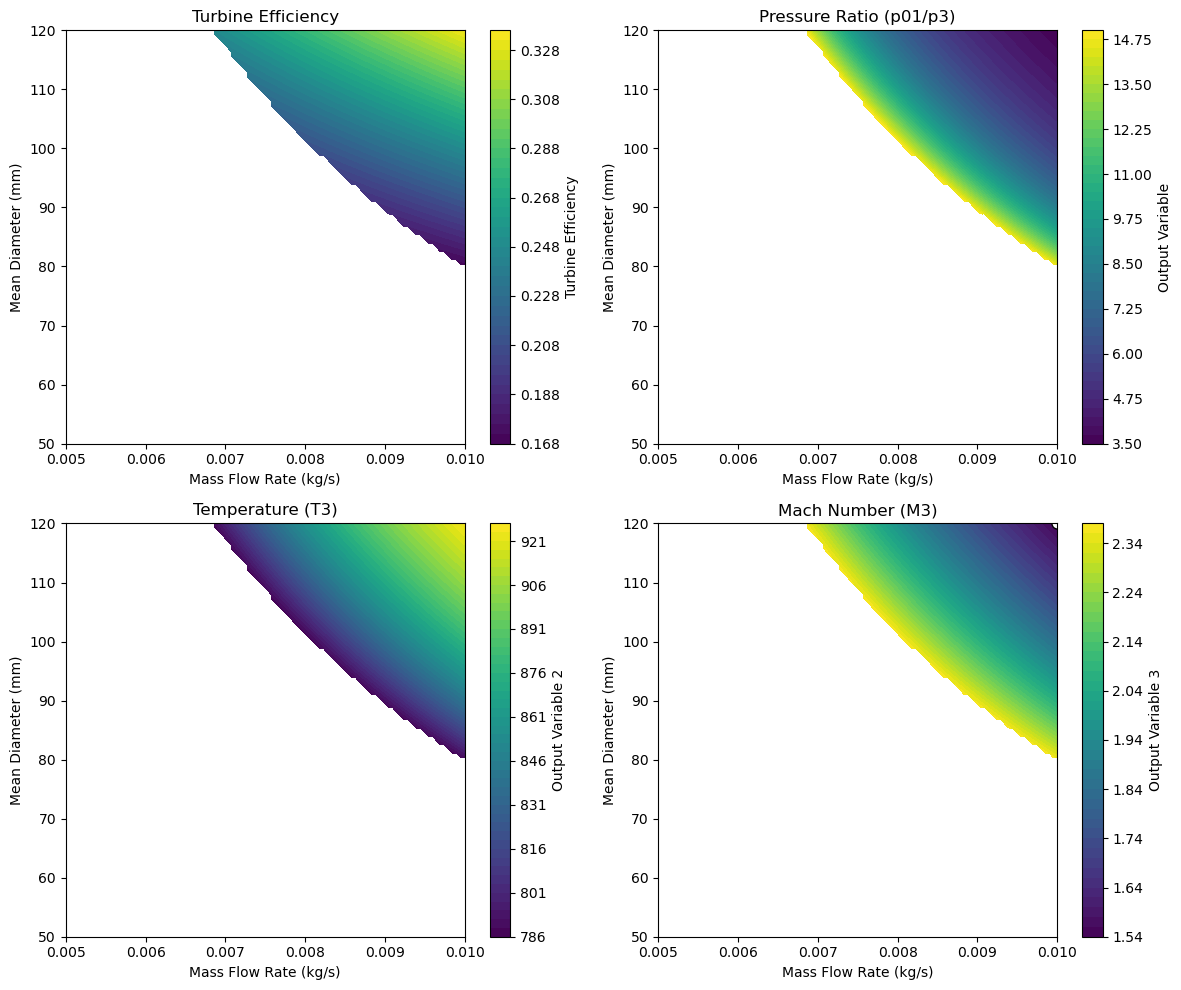

In [6]:
import numpy as np
from scipy.optimize import root_scalar
from rocketcea.cea_obj_w_units import CEA_Obj

from bearing import Bearing
from mechanicalseal import MechanicalSeal
import matplotlib.pyplot as plt

# from rocketcea.cea_obj import add_new_fuel
# from pyfluids import Fluid, FluidsList, Input
# import numpy as np

# class combustion_results:
#     def __init__(self, tc, cp):
#         self.tc = tc
#         self.cp = cp
    
#     def pretty_print(self):
#         print(f"Combustion Results:")
#         print(f"  {'Combustion Temperature (Tc)':<30} {self.tc:<10.4g} K")
#         print(f"  {'Combustion Heat Capacity (Cp)':<30} {self.cp:<10.4g} J/kg/K")

class GasGenerator:
    def __init__(self, ox: str, fuel: str):
        self.ox = ox
        self.fuel = fuel
        self.cea = CEA_Obj(
            oxName = self.ox,
            fuelName = self.fuel,
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/g',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)
    def combustion_sim(self, OF, pc):
        Tg_c = self.cea.get_Tcomb(Pc=pc, MR=OF)
        [mw_c, gam_c] = self.cea.get_Chamber_MolWt_gamma(Pc=pc, MR=OF, eps=40)
        R_c = 8314.5 / mw_c  # J/kg-K
        Cp_c = self.cea.get_Chamber_Cp(Pc=pc, MR=OF, eps=40)
        # print(f"mw={mw_c}, R={R_c}, gam={gam_c}, Cp={Cp_c}")
        return Tg_c, Cp_c, R_c, gam_c
    


class Engine:
    def __init__(self, ox: str, fuel: str):
        self.ox = ox
        self.fuel = fuel
        self.cea = CEA_Obj(
            oxName = self.ox,
            fuelName = self.fuel,
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/g',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)
        
    def size(self, OF, pc, pe, thrust):
        eps = self.cea.get_eps_at_PcOvPe(Pc=pc, MR=OF, PcOvPe=pc/pe)
        _, cf, _ = self.cea.get_PambCf(Pamb=pe, Pc=pc, MR=OF, eps=eps)
        at = thrust / (cf * pc * 1e5)
        cstar = self.cea.get_Cstar(Pc=pc, MR=OF)
        mdot = thrust / cstar
        isp_sea, _ = self.cea.estimate_Ambient_Isp(Pamb=pe, Pc=pc, MR=OF, eps=eps)
        return eps, cf, at, cstar, mdot, isp_sea
    
class Turbine:
    def __init__(self, 
                 P,       # W
                 RPM,     
                 d_mean_mm, # mm
                 T01,       # K
                 gam,
                 mdot,     # kg/s
                 cp,       # J/kg/K
                 R,         # J/kg/K
                #  p01_bar,    # bar
                 p_ratio,    # pressure ratio p01/p3
                 beta_deg,   # degrees
                 doa,       # degree of admission
                 pamb):     # ambient pressure [Pa]
        
        # Store inputs
        self.P = P
        self.RPM = RPM
        self.d_mean_mm = d_mean_mm
        self.T01 = T01
        self.gam = gam
        self.mdot = mdot
        self.cp = cp
        self.R = R
        # self.p01_bar = p01_bar
        self.p_ratio = p_ratio
        self.beta = np.deg2rad(beta_deg)
        self.doa = doa
        self.pamb = pamb
        
        # Derived inputs
        self.d_mean = d_mean_mm / 1000
        # self.p01 = p01_bar * 1e5
        self.p01 = self.p_ratio * pamb

        # Run calculations immediately
        self._compute()

    def _compute(self):
        # Angular velocity & blade speed
        self.w = self.RPM * 2 * np.pi / 60
        self.u = self.w * self.d_mean / 2
        
        # Useful enthalpy drop
        self.deltah_useful = self.P / self.mdot
        
        # Velocity triangles
        self.c3u = self.deltah_useful / (2 * self.u) + self.u
        self.c3 = self.c3u / np.cos(self.beta)
        self.c3m = self.c3 * np.sin(self.beta)

        # Swirl velocity at outlet
        self.c4u = self.u - (self.c3u - self.u)
        self.c4 = np.sqrt(self.c4u**2 + self.c3m**2)  
        
        # Outlet conditions
        self.T3 = self.T01 - 0.5 * self.c3**2 / self.cp
        self.a3 = np.sqrt(self.gam * self.R * self.T3)
        self.M3 = self.c3 / self.a3
        
        # Pressure & density at blade inlet
        self.p3 = self.p01 / (1 + 0.5 * (self.gam - 1) * self.M3**2)**(self.gam/(self.gam-1))
        self.rho_3 = self.p3 / (self.R * self.T3)
        
        # Blade height
        self.Height = self.mdot / (self.doa * self.rho_3 * self.c3m * self.d_mean)
        
        # Isentropic expansion to ambient
        # self.T_amb_is = self.T01 * (self.pamb/self.p01)**((self.gam - 1)/self.gam)
        # Isentropic expansion to static
        self.T_amb_is = self.T01 * (self.p3/self.p01)**((self.gam - 1)/self.gam)
        self.deltah_ambis = self.cp * (self.T01 - self.T_amb_is)
        
        # Efficiency
        self.eff = self.deltah_useful / self.deltah_ambis
        # Huzel and huang efficiency

        # Blade-jet speed ratio
        self.blade_jet_speed_ratio = self.u / np.sqrt(2 * self.deltah_ambis)

        # Specific Speed
        self.q = self.mdot / (self.rho_3)
        self.specific_speed = self.RPM * np.sqrt(self.q) / (self.P**(3/4))

        # Total throat area
        self.A = self.mdot / (self.p01 / np.sqrt(self.T01) * np.sqrt(self.gam / self.R) * ((2 / (self.gam + 1))**((self.gam + 1) / (2 * (self.gam - 1)))))

        # Throat to exit area ratio
        gam = self.gam
        self.eps = (( (gam + 1)/2 )**( - (gam + 1) / (2 * (gam - 1)) )) * ( 1 + 0.5 * (gam - 1) * self.M3**2 )**( (gam + 1) / (2 * (gam - 1)) ) * (1 / self.M3)

        # Nitrogen required calculations
        self.T01_n2 = 300  # K
        self.cp_n2 = 1040  # J/kg/K
        self.R_n2 = 296.8  # J/kg/K
        self.gam_n2 = 1.4

        rel_diff = 1
        p01_n2 = self.p01 * 5 # Initial guess
        iteration = 0


        def machfunc(mach, area_ratio, gam):
            if mach == 0:
                mach = 1e-7
            return area_ratio - ((1.0/mach) * ((1 + 0.5*(gam-1)*mach*mach) / ((gam + 1)/2))**((gam+1) / (2*(gam-1))))
        
        # self.M[i] = root_scalar(machfunc, args=(A, self.gamma[i]), bracket=[1, 5]).root
        
        while rel_diff > 5e-4:
            M3_n2 = root_scalar(machfunc, args=(self.eps, self.gam_n2), bracket=[1, 5]).root
            T3_n2 = self.T01_n2 / (1 + 0.5 * (self.gam_n2 - 1) * M3_n2**2)
            p3_n2 = p01_n2 / (1 + 0.5 * (self.gam_n2 - 1) * M3_n2**2)**(self.gam_n2/(self.gam_n2-1))
            rho3_n2 = p3_n2 / (self.R_n2 * T3_n2)
            
            c3_n2 = M3_n2 * np.sqrt(self.gam_n2 * self.R_n2 * T3_n2)

            c3u_n2 = c3_n2 * np.cos(self.beta)

            deltah_useful_n2 = 2 * self.u * (c3u_n2 - self.u)
            mdot_n2 = self.A * p01_n2 / np.sqrt(self.T01_n2) * np.sqrt(self.gam_n2 / self.R_n2) * ((2 / (self.gam_n2 + 1))**((self.gam_n2 + 1) / (2 * (self.gam_n2 - 1)))) 
            P_n2 = mdot_n2 * deltah_useful_n2

            rel_diff = abs((P_n2 - self.P) / self.P)
            # print(f"Iteration {iteration}: p01_n2 = {p01_n2/1e5:.2f} bar, p3_n2 = {p3_n2/1e5:.2f} bar, P_n2 = {P_n2:.2f} W, rel_diff = {rel_diff:.6f}")
            # print(f"it={iteration}, p01={p01_n2/1e5:.2f} bar, p3={p3_n2/1e5:.2f} bar, c3={c3_n2:.2f} m/s, M3={M3_n2:.2f}, P_n2={P_n2:.2f} W, rel_diff={rel_diff:.2e}")
            # print(f"mdot={mdot_n2*1000:.2f} g/s, deltah_useful={deltah_useful_n2:.2f} J/kg rho3={rho3_n2:.2f} kg/m3 T3={T3_n2:.2f} K")
            p01_n2 *= self.P / P_n2
            # p01_n2 *= np.sqrt(self.P / P_n2)
            iteration += 1

            
            self.p01_n2 = p01_n2
            self.M3_n2 = M3_n2
            self.T3_n2 = T3_n2
            self.p3_n2 = p3_n2
            self.rho3_n2 = rho3_n2
            self.c3_n2 = c3_n2
            self.c3u_n2 = c3u_n2
            self.deltah_useful_n2 = deltah_useful_n2
            self.mdot_n2 = mdot_n2
            self.P_n2 = P_n2
    

            if iteration > 100:
                break

    def pretty_print(self):
        print(f"Turbine Results:---------------------------")
        print(f"Inputs:")
        print(f"  {'Power (P)':<30} {self.P/1000:<10.4g} kW")
        print(f"  {'RPM':<30} {self.RPM:<10.4g} RPM")
        print(f"  {'Mean Diameter (d_mean)':<30} {self.d_mean_mm:<10.4g} mm")
        # print(f"  {'GG Temperature (T01)':<30} {self.T01:<10.4g} K")
        # print(f"  {'GG Heat Capacity Ratio (gam)':<30} {self.gam:<10.4g}")
        print(f"  {'GG mdot':<30} {self.mdot*1000:<10.4g} g/s")
        # print(f"  {'GG Heat Capacity':<30} {self.cp:<10.4g} J/Kg/K")
        # print(f"  {'GG Gas Constant':<30} {self.R:<10.4g} J/kg/K")
        # print(f"  {'GG Chamber Pressure':<30} {self.p01_bar:<10.4g} bar")
        print(f"  {'GG Pressure Ratio (p01/p3)':<30} {self.p_ratio:<10.4g}")
        print(f"  {'Nozzle Angle':<30} {np.rad2deg(self.beta):<10.4g} degree")
        print(f"  {'Degree of Admission':<30} {self.doa*100:<10.4g}%")
        print(f"Outputs:")
        print(f"  {'Rotor surface speed (u)':<30} {self.u:<10.4g} m/s")
        print(f"  {'Specific heat delta (dh_use)':<30} {self.deltah_useful:<10.4g} J/kg")
        print(f"  {'Absolute Circ. Velocity (c3u)':<30} {self.c3u:<10.4g} m/s")
        print(f"  {'Absolute Meri. Velocity (c3m)':<30} {self.c3m:<10.4g} m/s")
        print(f"  {'Absolute Velocity (c3)':<30} {self.c3:<10.4g} m/s")
        print(f"  {'Swirl Velocity (c4u)':<30} {self.c4u:<10.4g} m/s")
        print(f"  {'Absolute Velocity at exit (c4)':<30} {self.c4:<10.4g} m/s")
        print(f"  {'Exit Temperature (T3)':<30} {self.T3:<10.4g} K")
        print(f"  {'Exit sonic velocity (a3)':<30} {self.a3:<10.4g} m/s")
        print(f"  {'Exit Pressure (p3)':<30} {self.p3/1e5:<10.4g} bar")
        print(f"  {'Exit Density (rho_3)':<30} {self.rho_3:<10.4g} kg/m3")
        print(f"  {'Required Mach Number (M3)':<30} {self.M3:<10.4g}")
        print(f"  {'Required Blade Height (H_3)':<30} {self.Height*1000:<10.4g} mm")
        print(f"  {'Isen Ambient Temp (t_amb_is)':<30} {self.T_amb_is:<10.4g} K")
        print(f"  {'Turbine Efficiency (eff)':<30} {self.eff:<10.4g}")
        print(f"  {'Blade-Jet Speed Ratio':<30} {self.blade_jet_speed_ratio:<10.4g}")   
        print(f"  {'Throat Area (A)':<30} {self.A*1e6:<10.4g} mm2")
        print(f"  {'Area Ratio (eps)':<30} {self.eps:<10.4g}")   
        print(f"Nitrogen Testing Requirements:")
        print(f"  {'N2 Pressure (p01_n2)':<30} {self.p01_n2/1e5:<10.4g} bar")
        print(f"  {'N2 Temperature (T01_n2)':<30} {self.T01_n2:<10.4g} K")
        print(f"  {'N2 Mass Flow Rate (mdot_n2)':<30} {self.mdot_n2*1000:<10.4g} g/s")
        print(f"  {'N2 Exit Mach Number (M3_n2)':<30} {self.M3_n2:<10.4g}")
        print(f"  {'N2 Exit Temperature (T3_n2)':<30} {self.T3_n2:<10.4g} K")
        print(f"  {'N2 Exit Pressure (p3_n2)':<30} {self.p3_n2/1e5:<10.4g} bar")
        print(f"  {'N2 Exit Density (rho3_n2)':<30} {self.rho3_n2:<10.4g} kg/m3")
        print(f"  {'N2 Exit Velocity (c3_n2)':<30} {self.c3_n2:<10.4g} m/s")
        print(f"  {'N2 Specific heat delta (dh_n2)':<30} {self.deltah_useful_n2:<10.4g} J/kg")
        print(f"  {'N2 Power (P_n2)':<30} {self.P_n2/1000:<10.4g} kW") 

        
class BarskeImpeller:
    def __init__(self,
                 mdot_desired,  # kg/s
                 p_desired,    # Pa
                 rho,           # kg/m3
                 visc,          # Pa.s
                 RPM,
                 top_bearing,
                 bot_bearing,
                 mechanical_seal):
        self.mdot_desired = mdot_desired
        self.p_desired = p_desired
        self.rho = rho
        self.visc = visc
        self.RPM = RPM

        # Assumptions and calculations
        self.Q_desired = mdot_desired / rho
        self.coeff_p = 0.2
        g = 9.81
        self.H_desired = p_desired / (self.rho * g)  # m
        self.v_0 = 1 # Inlet velocity [m/s]
        self.d_0 = np.sqrt(4 * self.Q_desired / (np.pi * self.v_0))
        self.d_1 = 1.1 * self.d_0
        self.b_1 = 1.2 * 0.25 * self.d_1

        self.d_2 = np.sqrt((1 / (1 + self.coeff_p)) * (7200 * p_desired / (self.rho * self.RPM**2 * np.pi**2) + self.d_1**2))
        self.u_2 = self.RPM * np.pi * self.d_2 / 60
        self.u_1 = self.RPM * np.pi * self.d_1 / 60

        self.p_th = 0.5 * self.rho * (2 * self.u_2**2 - self.u_1**2)
        self.power_friction = 1956 * self.rho * self.visc**0.2 * (self.RPM/1000)**2.8 * (self.d_2**4.6 + 4.6 * self.d_1**3.6 * self.b_1)
        self.mechanical_loss = top_bearing.power_loss(self.RPM, 0.1, 0) + bot_bearing.power_loss(self.RPM, 0.1, 0) + mechanical_seal.power_loss(self.RPM, self.p_desired)
        self.power_loss = self.power_friction + self.mechanical_loss

        self.efficiency = self.p_desired / (self.p_th + (self.power_loss) / self.Q_desired)
        self.required_power = self.mdot_desired * self.p_desired / (self.rho * self.efficiency)

        self.hydraulic_work = self.required_power - self.mechanical_loss
        self.useful_hydraulic_work = self.hydraulic_work - self.power_friction
        self.static_enthalpy = self.mdot_desired * 0.5 * (self.u_2**2 - self.u_1**2) # WHAT IS THIS?
        self.theoretical_dynamic_enthalpy = self.mdot_desired * 0.5 * (self.u_2**2) # WHAT IS THIS?
        self.dynamic_enthalpy = self.mdot_desired * 0.5 * self.coeff_p * (self.u_2**2)
        self.useful_work = self.mdot_desired * 0.5 * ((1 + self.coeff_p) * self.u_2**2 - self.u_1**2)

        self.n_q = self.RPM * self.Q_desired**0.5 * self.H_desired**-0.75
        self.s_ax = min(0.00075, self.d_2 / 100)
        self.b_2 = max(1.5 * self.b_1 * self.d_1 / self.d_2, self.s_ax)
        self.B = 2 * self.s_ax + self.b_2
        self.H = max(self.B / 2, 0.0025)
        self.n_s = 150 # Lower estimate from lobanoff
        self.NPSHR = self.H_desired * (self.n_q / self.n_s)**(4/3)

        self.pressure_efficiency = self.p_desired / self.p_th
        self.head_coeff = 2 * self.H_desired * g / self.u_2**2
        self.v_3 = 0.8 * self.u_2  # Assuming a diffuser velocity coefficient of 0.8
        self.d_3 = np.sqrt(self.Q_desired / (self.v_3 * np.pi)) * 2
        self.d_4 = self.d_3 * 2
        self.v_4 = self.v_3 / 4
        self.blade_number = 6
        self.w = self.RPM * 2 * np.pi / 60
        self.torque = self.required_power / self.w
        self.tip_force = self.torque / (self.d_2 / 2) / self.blade_number
        self.blade_thickness = 0.0042
        self.blade_density = 1160
        self.blade_mass = self.b_2 * self.d_2 / 2 * self.blade_thickness * self.blade_density
        self.centrifugal_force = self.w**2 * self.d_2 / 2 * self.blade_mass
        self.blade_stress = self.centrifugal_force / (self.b_2 * self.blade_thickness)

    def pretty_print(self):
        print(f"Barske Impeller:---------------------------")
        print(f"Main results:")
        print(f"  {'RPM':<30} {self.RPM:.2f}")
        print(f"  {'Required Power':<30} {self.required_power:.2f} W")
        print(f"  {'Diameter at Outlet':<30} {self.d_2:.5f} m")
        print(f"  {"Mass flow rate (mdot)":<30} {self.mdot_desired:<10.4g} kg/s")
        print(f"  {"Outlet Head (H)":<30} {self.H_desired:<10.4g} m")
        print(f"  {"Rotational speed (n)":<30} {self.RPM:<10.4g} rpm")
        print(f"  {"Flow rate (Q)":<30} {self.Q_desired:<10.4g} m^3/s")
        print(f"  {"Specific speed (n_q)":<30} {self.n_q:<10.4g}")
        print(f"Detailed Results:")
        print(f"  {"Efficiency":<30} {self.efficiency:<10.4g}")
        print(f"  {"Inlet Diameter (d1)":<30} {self.d_0*1000:<10.4g} mm")
        print(f"  {"Impeller outlet diameter (d2)":<30} {self.d_2*1000:<10.4g} mm")
        print(f"  {"Impeller inlet diameter (d1)":<30} {self.d_1*1000:<10.4g} mm")
        print(f"  {"Power required (P)":<30} {self.required_power:<10.4g} W")
        print(f"  {"Blade height (b_1)":<30} {self.b_1*1000:<10.4g} mm")
        print(f"  {"Blade height (b_2)":<30} {self.b_2*1000:<10.4g} mm")
        print(f"  {"Axial Clearance (s_ax)":<30} {self.s_ax*1000:<10.4g} mm")
        print(f"  {"Radial Clearance (H)":<30} {self.H*1000:<10.4g} mm")
        print(f"  {"u_1":<30} {self.u_1:<10.4g} m/s")
        print(f"  {"u_2":<30} {self.u_2:<10.4g} m/s")
        print(f"  {"v_3":<30} {self.v_3:<10.4g} m/s")
        print(f"  {"v_4":<30} {self.v_4:<10.4g} m/s")
        print(f"  {"Mechanical Loss":<30} {self.mechanical_loss:<10.4g} W")
        print(f"  {"Friction Loss":<30} {self.power_friction:<10.4g} W")
        print(f"  {"Total Hydraulic Work":<30} {self.hydraulic_work:<10.4g} W")
        print(f"  {"Useful Hydraulic Work":<30} {self.useful_hydraulic_work:<10.4g} W")
        print(f"  {"Static Enthalpy":<30} {self.static_enthalpy:<10.4g} J/kg")
        print(f"  {"Theoretical Dynamic Enthalpy":<30} {self.theoretical_dynamic_enthalpy:<10.4g} J/kg")
        print(f"  {"Dynamic Enthalpy":<30} {self.dynamic_enthalpy:<10.4g} J/kg")
        print(f"  {"Useful Work":<30} {self.useful_work:<10.4g} J/kg")
        print(f"  {"Head Coefficient":<30} {self.head_coeff:<10.4g}")
        print(f"  {"Diffuser Diameter":<30} {self.d_3*1000:<10.4g} mm")
        print(f"  {"Diffuser Outlet Diameter":<30} {self.d_4*1000:<10.4g} mm")
        print(f"  {"Torque":<30} {self.torque:<10.4g} Nm")
        print(f"  {"Tip force":<30} {self.tip_force:<10.4g} N")
        print(f"  {"Centrifugal Force":<30} {self.centrifugal_force:<10.4g} N")
        print(f"  {"Blade Stress":<30} {self.blade_stress/1e6:<10.4g} MPa")
    
    def visualize(self):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Polygon, Circle, Rectangle

        # Create figure with two subplots - side view and top view
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        fig.suptitle('Barske Impeller Design', fontsize=16)

        # Side view (axial section)
        ax1.set_title('Meridonal View')
        ax1.set_xlabel('Axial Distance [mm]')
        ax1.set_ylabel('Radial Distance [mm]')
        ax1.set_aspect('equal')

        # Convert to mm for plotting
        rib_height = 0.003

        d0_mm = self.d_0 * 1000
        d1_mm = self.d_1 * 1000
        d2_mm = self.d_2 * 1000
        b1_mm = self.b_1 * 1000
        b2_mm = self.b_2 * 1000
        s_ax_mm = self.s_ax * 1000
        B_mm = self.B * 1000
        H_mm = self.H * 1000
        rib_height_mm = rib_height * 1000


        # Draw an example square
        ax1.plot([-10, 10], [0, 0], color='black', linestyle='--', label='Shaft Axis')

        ax1.plot([-10, -s_ax_mm], [-d0_mm/2, -d0_mm/2], color='green', linestyle='-')
        ax1.plot([-10, -s_ax_mm], [d0_mm/2, d0_mm/2], color='green', linestyle='-')
        # Draw top blade
        ax1.add_patch(Polygon([[0, d1_mm/2], [rib_height_mm + b1_mm - b2_mm, d2_mm/2], [rib_height_mm + b1_mm, d2_mm/2], [rib_height_mm + b1_mm, d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
        # Draw bottom blade
        ax1.add_patch(Polygon([[0, -d1_mm/2], [rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))
        # Draw rib
        ax1.add_patch(Rectangle((b1_mm, -d1_mm/2), rib_height_mm, d1_mm, fill=False, edgecolor='purple', linestyle='-', label='Rib'))
        # Draw top casing
        ax1.add_patch(Polygon([[-s_ax_mm, d0_mm/2],[-s_ax_mm, d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2 + H_mm], [rib_height_mm + b1_mm + s_ax_mm, d2_mm/2 + H_mm], [rib_height_mm + s_ax_mm + b1_mm, d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
        # Draw bottom casing
        ax1.add_patch(Polygon([[-s_ax_mm, -d0_mm/2],[-s_ax_mm, -d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2 - H_mm], [rib_height_mm + b1_mm + s_ax_mm, -d2_mm/2 - H_mm], [rib_height_mm + s_ax_mm + b1_mm, -d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))


        # Top view (radial section)
        ax2.set_title('Top View (Radial Section)')
        ax2.set_xlabel('X [mm]')
        ax2.set_ylabel('Y [mm]')
        ax2.set_aspect('equal')

        # Draw inlet, impeller and casing in top view
        ax2.add_patch(Circle((0, 0), d0_mm/2, fill=False, color='green', linestyle='-', label='Inlet (d₀)'))
        ax2.add_patch(Circle((0, 0), d1_mm/2, fill=False, color='blue', linestyle='-', label='Inner (d₁)'))
        ax2.add_patch(Circle((0, 0), d2_mm/2, fill=False, color='red', linestyle='-', label='Outer (d₂)'))
        ax2.add_patch(Circle((0, 0), d2_mm/2 + B_mm, fill=False, color='black', linestyle='--', label='Casing'))

        # Draw simplified blades (6 blades as typical for Barske design)
        blade_angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 equally spaced angles
        for angle in blade_angles:
            x1 = d1_mm/2 * np.cos(angle)
            y1 = d1_mm/2 * np.sin(angle)
            x2 = d2_mm/2 * np.cos(angle)
            y2 = d2_mm/2 * np.sin(angle)
            ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2)

        # Set axis limits with some padding
        max_dim = (d2_mm/2 + B_mm) * 1.2
        ax2.set_xlim(-max_dim, max_dim)
        ax2.set_ylim(-max_dim, max_dim)
        ax1.set_ylim(-max_dim, max_dim)
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()



# Example usage
if __name__ == "__main__":
    engine = Engine(ox='N2O', fuel='Isopropanol')
    eps, cf, at, cstar, mdot, isp_sea = engine.size(OF=2.5, pc=20, pe=1, thrust=1500)
    throat_diameter = np.sqrt(at / (np.pi/4))
    fuel_mdot = mdot / (1 + 2.5)
    oxidizer_mdot = mdot - fuel_mdot
    # print(f"Engine Sizing Results:-----------------------")
    # print(f"  {'Chamber Pressure':<30} {20:<10.4g} bar")
    # print(f"  {'Nozzle Exit Pressure':<30} {1:<10.4g} bar")
    # print(f"  {'Thrust':<30} {1500:<10.4g} N")
    # print(f"  {'Nozzle Expansion Ratio (eps)':<30} {eps:<10.4g}")
    # print(f"  {'Thrust Coefficient (cf)':<30} {cf:<10.4g}")
    # print(f"  {'Throat Diameter':<30} {throat_diameter*1000:<10.4g} mm")
    # print(f"  {'Characteristic Velocity (cstar)':<30} {cstar:<10.4g} m/s")
    # print(f"  {'Mass Flow Rate (mdot)':<30} {mdot:<10.4g} kg/s")
    # print(f"  {'Fuel Mass Flow Rate':<30} {fuel_mdot:<10.4g} kg/s")
    # print(f"  {'Oxidizer Mass Flow Rate':<30} {oxidizer_mdot:<10.4g} kg/s")
    # print(f"  {'Sea Level Isp (isp_sea)':<30} {isp_sea:<10.4g} s")

    gasgen = GasGenerator(ox='N2O', fuel='Isopropanol')
    Tg_c, Cp_c, R_c, gam_c = gasgen.combustion_sim(OF=0.5, pc=20)
    # print(f"Combustion Results:")
    print(f"  {'Combustion Temperature (Tc)':<30} {Tg_c:<10.4g} K")
    print(f"  {'Combustion Heat Capacity (Cp)':<30} {Cp_c:<10.4g} J/kg/K")
    print(f"  {'Combustion Gas Constant (R)':<30} {R_c:<10.4g} J/kg/K")
    print(f"  {'Combustion  gam (gam)':<30} {gam_c:<10.4g}")  

    top_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=False)
    bot_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=True)
    seal_59U14 = mechseal_59U14 = MechanicalSeal(OD_mm=19.5, ID_mm=15, BD_mm=14, F_sp=100)

    impeller = BarskeImpeller(
        mdot_desired=0.3,  # kg/s
        p_desired=20 * 1e5,    # Pa
        rho=1000,           # kg/m3
        visc=1.002e-6,          # Pa.s
        RPM=20000,
        top_bearing=top_bearing,
        bot_bearing=bot_bearing,
        mechanical_seal=seal_59U14)
    # impeller.pretty_print()
    # impeller.visualize()

    stage = Turbine(
        P=2600,       # W
        RPM=20000,     
        d_mean_mm=400, # mm
        T01=Tg_c,       # K
        gam=gam_c,
        mdot=0.01,     # kg/s
        cp=Cp_c,       # J/kg/K
        R=R_c,         # J/kg/K
        # p01_bar=10,    # bar
        p_ratio=15,    # bar
        beta_deg=15,   # degrees
        doa=0.2,       # degree of admission
        pamb=1e5)     # ambient pressure [Pa]
    # stage.pretty_print()

    parameters1 = np.linspace(50, 120, 100)
    parameters2 = np.linspace(0.005, 0.01, 100)

    efficiencies = np.zeros((len(parameters1), len(parameters2)))
    output = np.zeros((len(parameters1), len(parameters2)))
    output2 = np.zeros((len(parameters1), len(parameters2)))
    output3 = np.zeros((len(parameters1), len(parameters2)))
    for i, diameter in enumerate(parameters1):
        for j, mdot in enumerate(parameters2):
            try:
                stage = Turbine(
                    P=2600,       # W
                    RPM=20000,     
                    d_mean_mm=diameter, # mm
                    T01=Tg_c,       # K
                    gam=gam_c,
                    mdot=mdot,     # kg/s
                    cp=Cp_c/2,       # J/kg/K
                    R=R_c,         # J/kg/K
                    # p01_bar=10,    # bar
                    p_ratio=15,    # bar
                    beta_deg=15,   # degrees
                    doa=0.2,       # degree of admission
                    pamb=1e5)     # ambient pressure [Pa]
                efficiencies[i, j] = stage.eff
                output[i, j] = np.minimum(stage.p01 / stage.p3, 30)
                output2[i, j] = stage.T3
                output3[i, j] = stage.M3
                if stage.T3 < 0 or stage.p3 < stage.pamb:
                    efficiencies[i, j] = np.nan
                    output[i, j] = np.nan
                    output2[i, j] = np.nan
                    output3[i, j] = np.nan
            except:
                efficiencies[i, j] = np.nan
                output[i, j] = np.nan
                output2[i, j] = np.nan
                output3[i, j] = np.nan
    # Plot efficiency heatmap
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Top-left: Efficiency
    eff_masked = np.ma.array(efficiencies, mask=np.isnan(efficiencies))
    cs0 = axs[0, 0].contourf(parameters2, parameters1, eff_masked, levels=50, cmap='viridis')
    fig.colorbar(cs0, ax=axs[0, 0], label='Turbine Efficiency')
    axs[0, 0].set_xlabel('Mass Flow Rate (kg/s)')
    axs[0, 0].set_ylabel('Mean Diameter (mm)')
    axs[0, 0].set_title('Turbine Efficiency')

    # Top-right: Output variable
    out_masked = np.ma.array(output, mask=np.isnan(output))
    cs1 = axs[0, 1].contourf(parameters2, parameters1, out_masked, levels=50, cmap='viridis')
    fig.colorbar(cs1, ax=axs[0, 1], label='Output Variable')
    axs[0, 1].set_xlabel('Mass Flow Rate (kg/s)')
    axs[0, 1].set_ylabel('Mean Diameter (mm)')
    axs[0, 1].set_title('Pressure Ratio (p01/p3)')

    # Bottom-left: Output variable 2
        
    out2_masked = np.ma.array(output2, mask=np.isnan(output2))
    cs2 = axs[1, 0].contourf(parameters2, parameters1, out2_masked, levels=50, cmap='viridis')
    fig.colorbar(cs2, ax=axs[1, 0], label='Output Variable 2')
    axs[1, 0].set_xlabel('Mass Flow Rate (kg/s)')
    axs[1, 0].set_ylabel('Mean Diameter (mm)')
    axs[1, 0].set_title('Temperature (T3)')

    # Bottom-right: Output variable 3
    out3_masked = np.ma.array(output3, mask=np.isnan(output3))
    cs3 = axs[1, 1].contourf(parameters2, parameters1, out3_masked, levels=50, cmap='viridis')
    fig.colorbar(cs3, ax=axs[1, 1], label='Output Variable 3')
    axs[1, 1].set_xlabel('Mass Flow Rate (kg/s)')
    axs[1, 1].set_ylabel('Mean Diameter (mm)')
    axs[1, 1].set_title('Mach Number (M3)')

    # Mark maximum efficiency point if any valid data exists
    if not np.all(np.isnan(efficiencies)):
        idx_flat = np.nanargmax(efficiencies)
        i_best, j_best = np.unravel_index(idx_flat, efficiencies.shape)
        axs[1, 1].plot(parameters2[j_best], parameters1[i_best], 'wo', markeredgecolor='k', markersize=8)
        axs[1, 1].text(parameters2[j_best], parameters1[i_best], f' max\n({parameters2[j_best]:.4g}, {parameters1[i_best]:.0f})',
                       color='white', fontsize=8, ha='left', va='bottom')
        
        eff_max = efficiencies[i_best, j_best]
        print(f"Maximum Efficiency: {eff_max:.4g} at Diameter = {parameters1[i_best]:.2f} mm, Mass Flow Rate = {parameters2[j_best]:.4g} kg/s")
        # print U/c0
        blade_jet_speed_ratio = (parameters1[i_best]/1000 * np.pi * stage.RPM / 60) / stage.c3
        print(f"Blade-Jet Speed Ratio at Max Efficiency: {blade_jet_speed_ratio:.4g}")

    plt.tight_layout()
    plt.show()



    

    
